In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as pl
%matplotlib inline
from scipy import stats
import shap
import sys

import warnings
warnings.filterwarnings("ignore")

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

from utils import *

## Loading data

In [3]:
path = ''
df_original = pd.read_csv(path + 'data/german.data', sep=' ', header=None)
df_original.columns = ['status_account', 'duration_month', 'credit_history', 'purpose',
                       'credit_amount', 'savings_account', 'employment_since', 'installment_rate',
                       'sex', 'other_debtors', 'residence_since', 'property', 'age', 
                       'installment_plans', 'housing', 'number_credits_this_bank', 'job', 
                       'people_liable_for', 'telephone', 'foreign_worker', 'credit_risk']
print(df_original.shape)
df_original.head()

(1000, 21)


,status_account,duration_month,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,sex,other_debtors,residence_since,property,age,installment_plans,housing,number_credits_this_bank,job,people_liable_for,telephone,foreign_worker,credit_risk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201,2


## Preprocessing

In [4]:
df_proces = df_original.copy()

df_proces['credit_risk'] = df_proces['credit_risk'].apply(lambda row: 1 if row == 1 else 0)
df_proces['age'] = df_proces['age'].apply(lambda row: 0 if row <= 25 else 1)
columns_cat = ['sex', 'status_account', 'credit_history', 'purpose', 'savings_account',
               'employment_since', 'other_debtors', 'property', 'installment_plans',
               'housing', 'job', 'telephone', 'foreign_worker']

df_proces = pd.get_dummies(df_proces, columns=columns_cat)
df_proces = df_proces.astype(float)
df_proces.head()

,duration_month,credit_amount,installment_rate,residence_since,age,number_credits_this_bank,people_liable_for,credit_risk,sex_A91,sex_A92,sex_A93,sex_A94,status_account_A11,status_account_A12,status_account_A13,status_account_A14,credit_history_A30,credit_history_A31,credit_history_A32,credit_history_A33,credit_history_A34,purpose_A40,purpose_A41,purpose_A410,purpose_A42,purpose_A43,purpose_A44,purpose_A45,purpose_A46,purpose_A48,purpose_A49,savings_account_A61,savings_account_A62,savings_account_A63,savings_account_A64,savings_account_A65,employment_since_A71,employment_since_A72,employment_since_A73,employment_since_A74,employment_since_A75,other_debtors_A101,other_debtors_A102,other_debtors_A103,property_A121,property_A122,property_A123,property_A124,installment_plans_A141,installment_plans_A142,installment_plans_A143,housing_A151,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174,telephone_A191,telephone_A192,foreign_worker_A201,foreign_worker_A202
0,6.0,1169.0,4.0,4.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,48.0,5951.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,12.0,2096.0,2.0,3.0,1.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,42.0,7882.0,2.0,4.0,1.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,24.0,4870.0,3.0,4.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [5]:
metadata = {'label_maps': [{0.0: 'Bad', 1.0: 'Good'}], 
            'protected_attribute_maps': [{0.0: 'young', 1.0: 'aged'}]}
unprivileged_groups=[{'age': [0.0]}]
privileged_groups=[{'age': [1.0]}]
protected_attribute_names = ['age']
label_names = ['credit_risk']
dataset = BinaryLabelDataset(df = df_proces, label_names=label_names, 
                            protected_attribute_names = protected_attribute_names, 
                            instance_weights_name=None, unprivileged_protected_attributes=[], 
                            privileged_protected_attributes=[], metadata=metadata)

metric_orig = BinaryLabelDatasetMetric(dataset,
                                       unprivileged_groups=unprivileged_groups,
                                       privileged_groups=privileged_groups)
disparate_impact_orig = metric_orig.disparate_impact()
print('Disparate impact dados originais: ', (1 - disparate_impact_orig))
position = 4
name_protect = 'age'

Disparate impact dados originais:  0.20517395182872433


In [6]:
lst_res = []

## Model with original data

In [7]:
dataset_train, dataset_test = dataset.split([0.7], shuffle=False)

scale = StandardScaler().fit(dataset_train.features)
X_train_orig = scale.transform(dataset_train.features)
y_train = dataset_train.labels.ravel()
X_test_orig = scale.transform(dataset_test.features)
y_test = dataset_test.labels.ravel()

### Random Forest

In [8]:
model_orig_rf = RandomForestClassifier(n_estimators=100, min_samples_split=10, max_depth=10)
model_orig_rf.fit(X_train_orig, y_train) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [9]:
print('RESULT WITH RANDOM FOREST WITH ORIGINAL DATA: \n')

result = compute_metrics(model_orig_rf, X_test_orig, y_test, X_train_orig, y_train, 
                         dataset_test, 'german', 'rf_orig', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH RANDOM FOREST WITH ORIGINAL DATA: 

Test accuracy:  0.7633333333333333
Train accuracy:  0.8942857142857142
Disparate impact:  0.8826259946949602
Mean difference:  -0.10088344257623261
Average odds difference: -0.039622524368287115
Equality of opportunity: -0.004519774011299438
False discovery rate difference: 0.16171328671328672
Generalized entropy index: 0.08097038437303096
Consistency:  0.8620000000000001


### Gradient Boosting

In [10]:
model_orig_gbm = GradientBoostingClassifier()
model_orig_gbm.fit(X_train_orig, y_train) 

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [11]:
print('RESULT WITH GRADIENT BOOSTING WITH ORIGINAL DATA: \n')

result = compute_metrics(model_orig_gbm, X_test_orig, y_test, X_train_orig, y_train, 
                         dataset_test, 'german', 'gbm_orig', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH GRADIENT BOOSTING WITH ORIGINAL DATA: 

Test accuracy:  0.75
Train accuracy:  0.9114285714285715
Disparate impact:  0.8683703833362507
Mean difference:  -0.10715303505272156
Average odds difference: -0.04026975849009751
Equality of opportunity: -0.031638418079096065
False discovery rate difference: 0.17296025752135694
Generalized entropy index: 0.09829683920373125
Consistency:  0.8053333333333332


### Logistic Regression

In [12]:
model_orig_lr = LogisticRegression()
model_orig_lr.fit(X_train_orig, y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [13]:
print('RESULT WITH LOGISTIC REGRESSION WITH ORIGINAL DATA: \n')

result = compute_metrics(model_orig_lr, X_test_orig, y_test, X_train_orig, y_train, 
                         dataset_test, 'german', 'lr_orig', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH LOGISTIC REGRESSION WITH ORIGINAL DATA: 

Test accuracy:  0.7633333333333333
Train accuracy:  0.7885714285714286
Disparate impact:  0.7068023365366496
Mean difference:  -0.22171558848674844
Average odds difference: -0.12953374309306515
Equality of opportunity: -0.17005649717514126
False discovery rate difference: 0.16411069980609905
Generalized entropy index: 0.11273859669598603
Consistency:  0.8106666666666666


## Model with transformed data

In [14]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
RW.fit(dataset_train)
dataset_transf_train = RW.transform(dataset_train)

In [15]:
metric_transf = BinaryLabelDatasetMetric(dataset_transf_train,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
disparate_impact_transf = metric_transf.disparate_impact()
print('Disparate impact dados transformados: ', (1 - disparate_impact_transf))

Disparate impact dados transformados:  1.1102230246251565e-16


In [16]:
scale_transf = StandardScaler().fit(dataset_transf_train.features) 
X_train_transf = scale.transform(dataset_transf_train.features)  
y_train = dataset_transf_train.labels.ravel()
X_test_transf = scale_transf.transform(dataset_test.features) 
y_test = dataset_test.labels.ravel()

### Random Forest

In [17]:
model_transf_rf = RandomForestClassifier(n_estimators=100, min_samples_split=10, max_depth=10)
model_transf_rf.fit(X_train_transf, y_train,
                 sample_weight=dataset_transf_train.instance_weights)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [18]:
print('RESULT WITH RANDOM FOREST WITH TRANSFORMED DATA: \n')

result = compute_metrics(model_transf_rf, X_test_transf, y_test, X_train_transf, y_train, 
                         dataset_test, 'german', 'rf_transf', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH RANDOM FOREST WITH TRANSFORMED DATA: 

Test accuracy:  0.76
Train accuracy:  0.8914285714285715
Disparate impact:  0.9643786597267404
Mean difference:  -0.031205471644343064
Average odds difference: 0.02624790463773513
Equality of opportunity: 0.05084745762711862
False discovery rate difference: 0.18020793222949555
Generalized entropy index: 0.07454754380925036
Consistency:  0.8793333333333333


### Gradient Boosting

In [19]:
model_transf_gbm = GradientBoostingClassifier()
model_transf_gbm.fit(X_train_transf, y_train,
                 sample_weight=dataset_transf_train.instance_weights)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [20]:
print('RESULT WITH GRADIENT BOOSTING WITH TRANSFORMED DATA: \n')

result = compute_metrics(model_transf_gbm, X_test_transf, y_test, X_train_transf, y_train, 
                         dataset_test, 'german', 'gbm_transf', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH GRADIENT BOOSTING WITH TRANSFORMED DATA: 

Test accuracy:  0.7533333333333333
Train accuracy:  0.9071428571428571
Disparate impact:  0.8986737400530505
Mean difference:  -0.08164719293245937
Average odds difference: -0.013085925374060947
Equality of opportunity: 0.007344632768361614
False discovery rate difference: 0.16739926739926742
Generalized entropy index: 0.09779614325068864
Consistency:  0.8106666666666665


### Logistic Regression

In [21]:
model_transf_lr = LogisticRegression()
model_transf_lr.fit(X_train_transf, y_train,
                    sample_weight=dataset_transf_train.instance_weights)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [22]:
print('RESULT WITH LOGISTIC REGRESSION WITH TRANSFORMED DATA: \n')

result = compute_metrics(model_transf_lr, X_test_transf, y_test, X_train_transf, y_train, 
                         dataset_test, 'german', 'lr_transf', unprivileged_groups, 
                         privileged_groups, position)
lst_res.append(result)

RESULT WITH LOGISTIC REGRESSION WITH TRANSFORMED DATA: 

Test accuracy:  0.7566666666666667
Train accuracy:  0.7828571428571428
Disparate impact:  0.9628647214854111
Mean difference:  -0.027928184667996625
Average odds difference: 0.06982523126590923
Equality of opportunity: -0.03672316384180785
False discovery rate difference: 0.2509157509157509
Generalized entropy index: 0.10752918229856
Consistency:  0.8093333333333332


In [23]:
cols_name = ['dataset', 'name_exp', 'acc_test', 'disp_impact_bin', 'mean_difference',
             'disp_impact_clf', 'avg_odds', 'equal_opport', 'false_discovery_rate', 
             'entropy_index', 'consistency']

df_final = pd.DataFrame(lst_res, columns=cols_name)
df_final

,dataset,name_exp,acc_test,disp_impact_bin,mean_difference,disp_impact_clf,avg_odds,equal_opport,false_discovery_rate,entropy_index,consistency
0,german,rf_orig,0.763333,0.882626,-0.100883,0.882626,-0.039623,-0.004520,0.161713,0.080970,0.862000
1,german,gbm_orig,0.750000,0.868370,-0.107153,0.868370,-0.040270,-0.031638,0.172960,0.098297,0.805333
2,german,lr_orig,0.763333,0.706802,-0.221716,0.706802,-0.129534,-0.170056,0.164111,0.112739,0.810667
3,german,rf_transf,0.760000,0.964379,-0.031205,0.964379,0.026248,0.050847,0.180208,0.074548,0.879333
4,german,gbm_transf,0.753333,0.898674,-0.081647,0.898674,-0.013086,0.007345,0.167399,0.097796,0.810667
5,german,lr_transf,0.756667,0.962865,-0.027928,0.962865,0.069825,-0.036723,0.250916,0.107529,0.809333


## SHAP

In [24]:
lst_shape = []

### Random Forest

RESULTS WITH RANDOM FOREST WITH ORIGINAL DATA: 



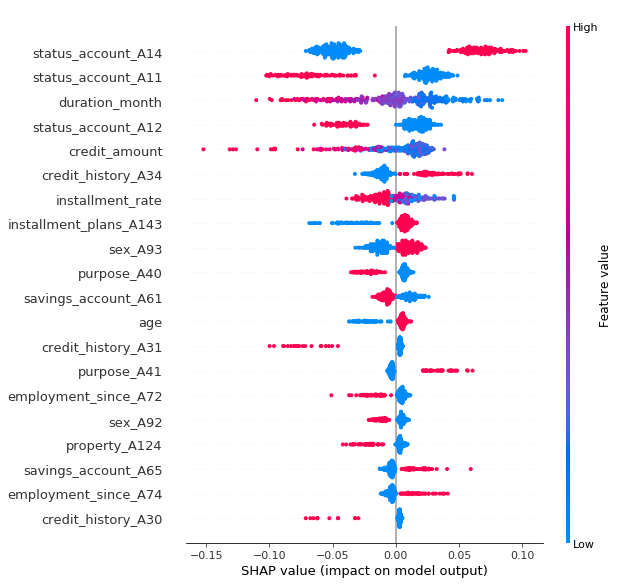

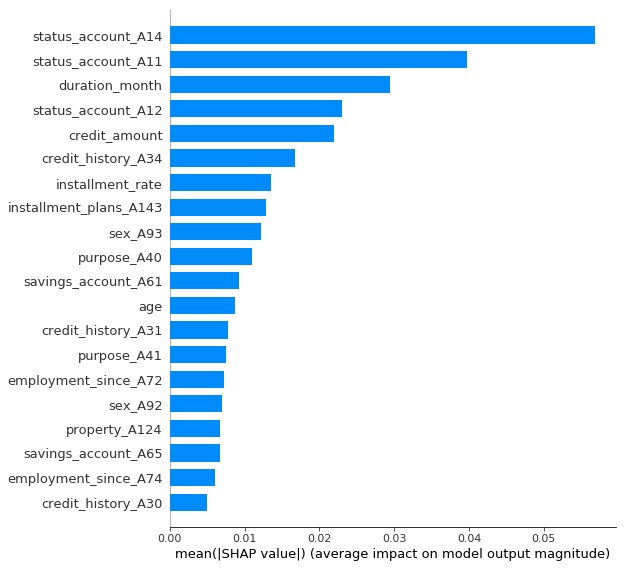

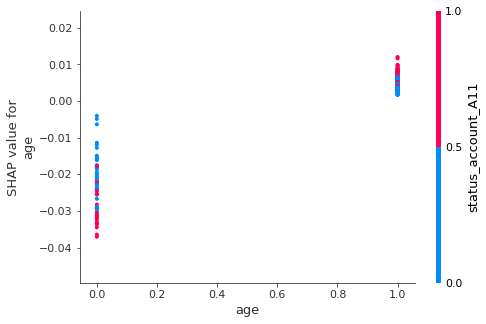

Mean SHAP value unprivileged class:  -0.023383807033800795
Mean SHAP value privileged class:  0.005260924079196465
reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad


In [25]:
print('RESULTS WITH RANDOM FOREST WITH ORIGINAL DATA: \n')
df_feat, shap_results = tree_shap_results(model_orig_rf, 'rf_orig', X_train_orig, 
                                            X_test_orig, dataset_test, name_protect, position)
lst_shape.append(shap_results)

In [26]:
print('Global SHAP values by feature of Random Forest with original data: ')
df_feat

Global SHAP values by feature of Random Forest with original data: 


,feature_names,value
0,status_account_A14,0.056825
1,status_account_A11,0.039729
2,duration_month,0.029507
3,status_account_A12,0.023051
4,credit_amount,0.022017
5,credit_history_A34,0.016771
6,installment_rate,0.013581
7,installment_plans_A143,0.012888
8,sex_A93,0.012159
9,purpose_A40,0.010978


RESULTS WITH RANDOM FOREST WITH TRANSFORMED DATA: 



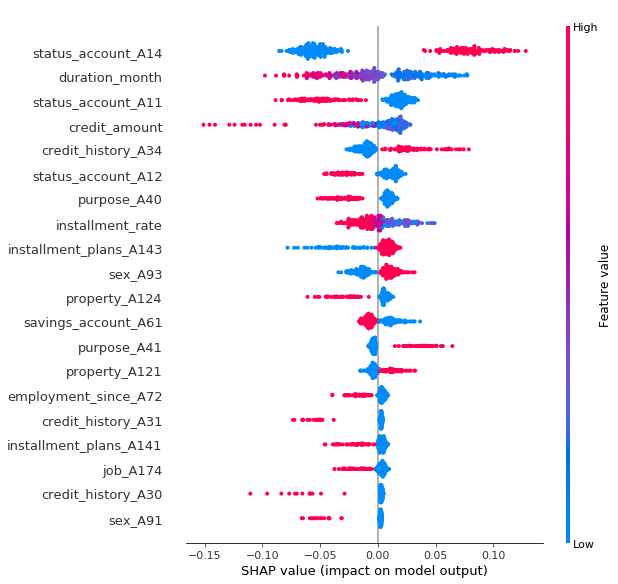

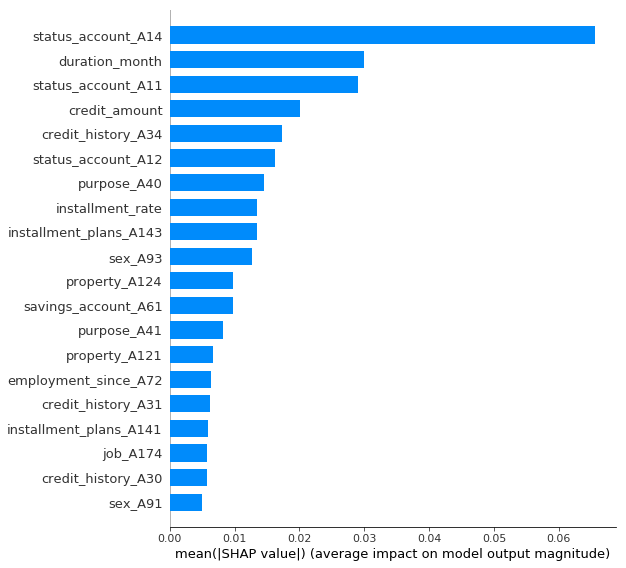

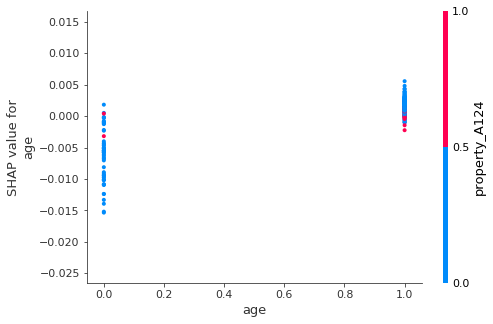

Mean SHAP value unprivileged class:  -0.006177307113124778
Mean SHAP value privileged class:  0.0014603779939268617
reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad


In [27]:
print('RESULTS WITH RANDOM FOREST WITH TRANSFORMED DATA: \n')
df_feat, shap_results = tree_shap_results(model_transf_rf, 'rf_transf', X_train_transf, 
                                          X_test_transf, dataset_test, name_protect, 
                                          position)
lst_shape.append(shap_results)

In [28]:
print('Global SHAP values by feature of Random Forest with transformed data: ')
df_feat

Global SHAP values by feature of Random Forest with transformed data: 


,feature_names,value
0,status_account_A14,0.065555
1,duration_month,0.029903
2,status_account_A11,0.028971
3,credit_amount,0.020161
4,credit_history_A34,0.017349
5,status_account_A12,0.016298
6,purpose_A40,0.014496
7,installment_rate,0.013537
8,installment_plans_A143,0.013406
9,sex_A93,0.012759


### Gradient Boosting

RESULTS WITH GRADIENT BOOSTING WITH ORIGINAL DATA: 



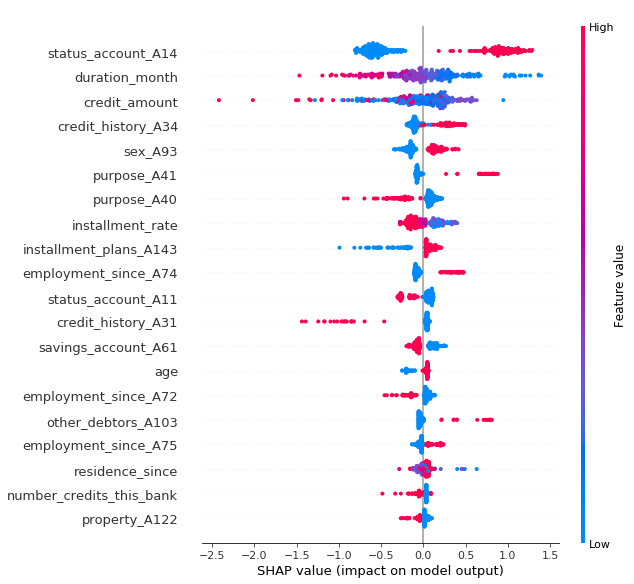

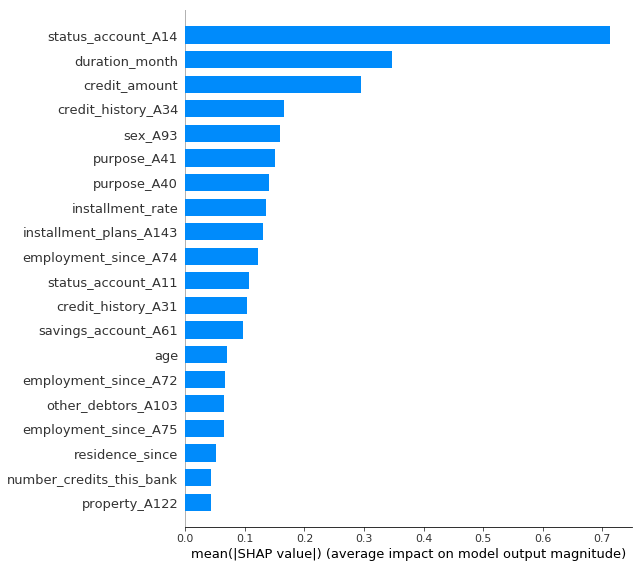

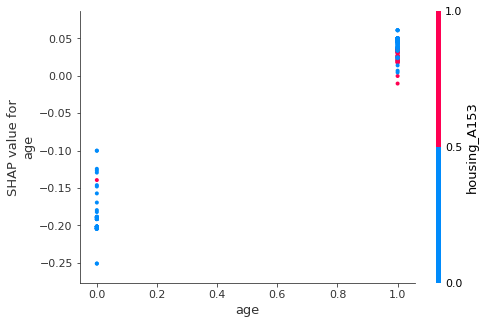

Mean SHAP value unprivileged class:  -0.18894223581535788
Mean SHAP value privileged class:  0.04213978206719815
reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad


In [29]:
print('RESULTS WITH GRADIENT BOOSTING WITH ORIGINAL DATA: \n')
df_feat, shap_results = tree_shap_results(model_orig_gbm, 'gbm_orig', X_train_orig, 
                                          X_test_orig, dataset_test, name_protect, position)
lst_shape.append(shap_results)

In [30]:
print('Global SHAP values by feature of Gradient Boosting with original data: ')
df_feat

Global SHAP values by feature of Gradient Boosting with original data: 


,feature_names,value
0,status_account_A14,0.713353
1,duration_month,0.346497
2,credit_amount,0.295687
3,credit_history_A34,0.165267
4,sex_A93,0.159532
5,purpose_A41,0.150411
6,purpose_A40,0.140288
7,installment_rate,0.134997
8,installment_plans_A143,0.130431
9,employment_since_A74,0.122459


RESULTS WITH GRADIENT BOOSTING WITH TRANSFORMED DATA: 



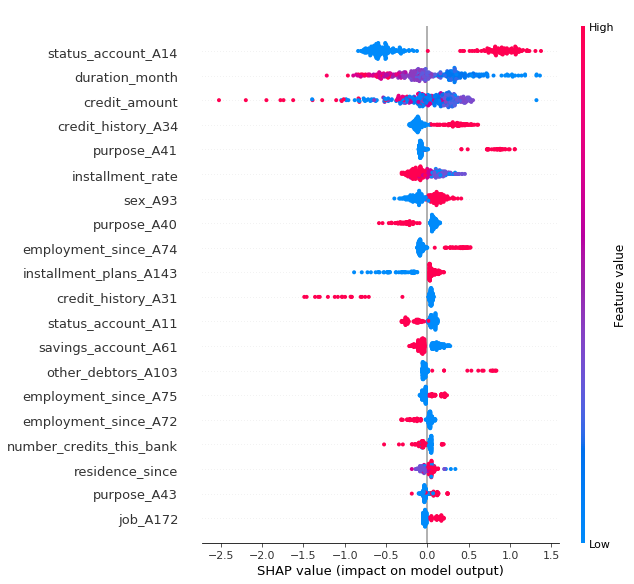

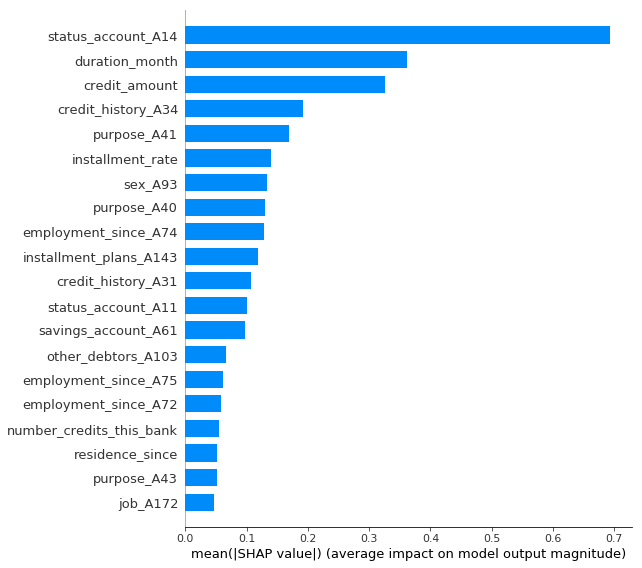

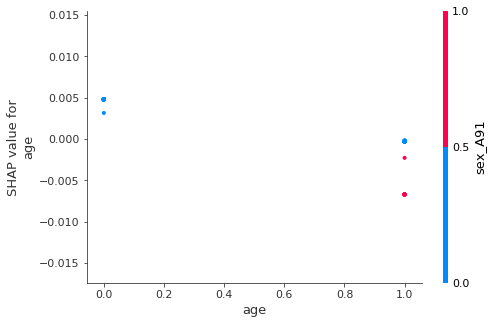

Mean SHAP value unprivileged class:  0.004771002123703145
Mean SHAP value privileged class:  -0.0007095584936125548
accept null hypothesis, mean of group privilegiad is NOT greater than mean of unprivilegiad


In [31]:
print('RESULTS WITH GRADIENT BOOSTING WITH TRANSFORMED DATA: \n')
df_feat, shap_results = tree_shap_results(model_transf_gbm, 'gbm_transf', X_train_transf, 
                                          X_test_transf, dataset_test, name_protect, 
                                          position)
lst_shape.append(shap_results)

In [32]:
print('Global SHAP values by feature of Gradient Boosting with transformed data: ')
df_feat

Global SHAP values by feature of Gradient Boosting with transformed data: 


,feature_names,value
0,status_account_A14,0.693505
1,duration_month,0.362070
2,credit_amount,0.325231
3,credit_history_A34,0.191858
4,purpose_A41,0.169013
5,installment_rate,0.139779
6,sex_A93,0.134115
7,purpose_A40,0.129895
8,employment_since_A74,0.127765
9,installment_plans_A143,0.118570


### Logistic Regression

RESULTS WITH LOGISTIC REGRESION WITH ORIGINAL DATA: 



Estimating transforms: 100%|██████████| 1000/1000 [00:11<00:00, 84.19it/s]


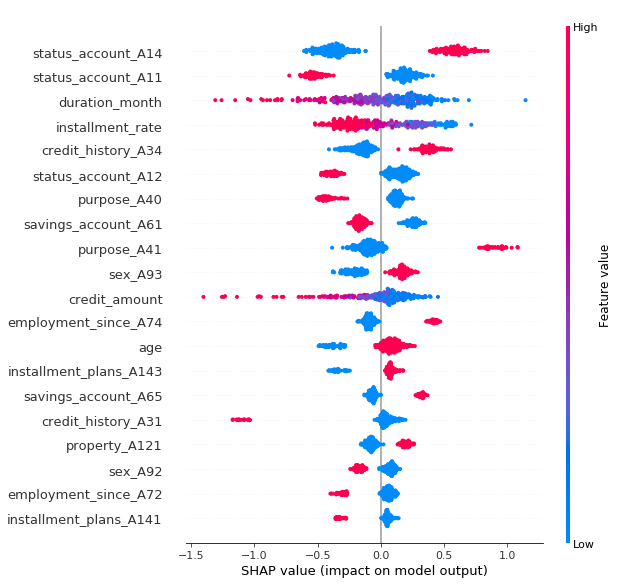

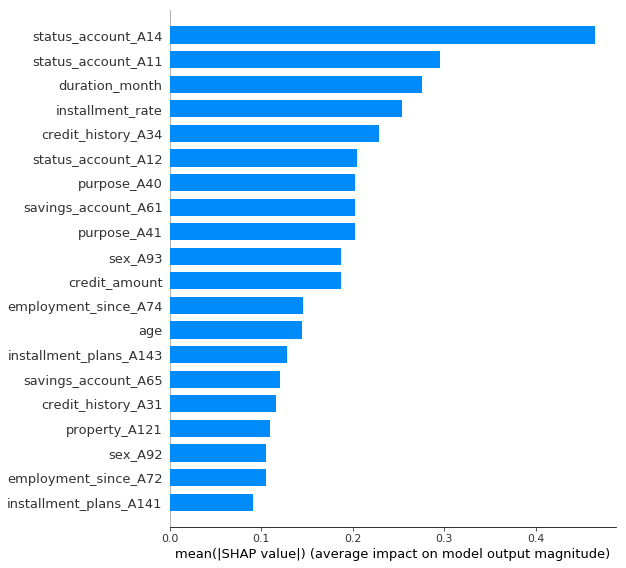

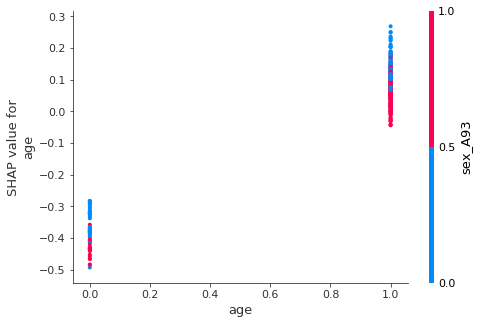

Mean SHAP value unprivileged class:  -0.3750521030195669
Mean SHAP value privileged class:  0.0871963058192172
reject null hypothesis, mean of group privilegiad is greater than mean of unprivilegiad


In [33]:
print('RESULTS WITH LOGISTIC REGRESION WITH ORIGINAL DATA: \n')
sys.stdout.flush()
df_feat, shap_results = linear_shap_results(model_orig_lr, 'lr_orig', X_train_orig, 
                                            X_test_orig, dataset_test, name_protect, 
                                            position)
lst_shape.append(shap_results)

In [34]:
print('Global SHAP values by feature of Logistic Regression with original data: ')
df_feat

Global SHAP values by feature of Logistic Regression with original data: 


,feature_names,value
0,status_account_A14,0.464534
1,status_account_A11,0.295195
2,duration_month,0.275829
3,installment_rate,0.254089
4,credit_history_A34,0.228717
5,status_account_A12,0.204334
6,purpose_A40,0.202889
7,savings_account_A61,0.202730
8,purpose_A41,0.202384
9,sex_A93,0.186972


RESULTS WITH LOGISTIC REGRESION WITH TRANSFORMED DATA: 



Estimating transforms: 100%|██████████| 1000/1000 [00:11<00:00, 88.03it/s]


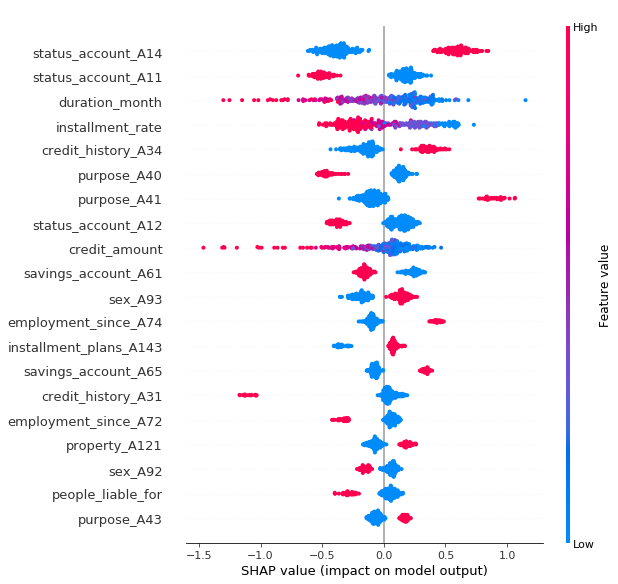

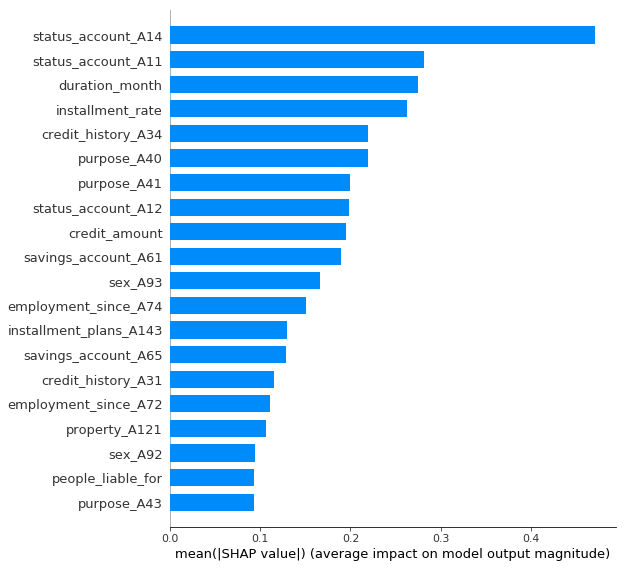

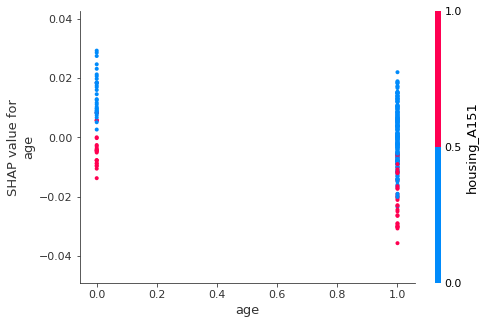

Mean SHAP value unprivileged class:  0.006848635039119124
Mean SHAP value privileged class:  -0.0020267093945386394
accept null hypothesis, mean of group privilegiad is NOT greater than mean of unprivilegiad


In [35]:
print('RESULTS WITH LOGISTIC REGRESION WITH TRANSFORMED DATA: \n')
sys.stdout.flush()
df_feat, shap_results = linear_shap_results(model_transf_lr, 'lr_transf', X_train_transf, 
                                            X_test_transf, dataset_test, name_protect, 
                                            position)
lst_shape.append(shap_results)

In [36]:
print('Global SHAP values by feature of Logistic Regression with transformed data: ')
df_feat

Global SHAP values by feature of Logistic Regression with transformed data: 


,feature_names,value
0,status_account_A14,0.470589
1,status_account_A11,0.280974
2,duration_month,0.274604
3,installment_rate,0.263075
4,credit_history_A34,0.219374
5,purpose_A40,0.219084
6,purpose_A41,0.199416
7,status_account_A12,0.198625
8,credit_amount,0.195172
9,savings_account_A61,0.189196


### Final result

In [37]:
df_shap = pd.DataFrame(lst_shape, columns=['name_exp', 'feat_imp', 'shap_rank', 'mean_unpriv', 'mean_priv', 'priv_greater_unpriv'])
df_final = pd.merge(df_shap, df_final, on='name_exp')
df_final

,name_exp,feat_imp,shap_rank,mean_unpriv,mean_priv,priv_greater_unpriv,dataset,acc_test,disp_impact_bin,mean_difference,disp_impact_clf,avg_odds,equal_opport,false_discovery_rate,entropy_index,consistency
0,rf_orig,0.008765,11,-0.023384,0.005261,1,german,0.763333,0.882626,-0.100883,0.882626,-0.039623,-0.004520,0.161713,0.080970,0.862000
1,rf_transf,0.002462,36,-0.006177,0.001460,1,german,0.760000,0.964379,-0.031205,0.964379,0.026248,0.050847,0.180208,0.074548,0.879333
2,gbm_orig,0.070592,13,-0.188942,0.042140,1,german,0.750000,0.868370,-0.107153,0.868370,-0.040270,-0.031638,0.172960,0.098297,0.805333
3,gbm_transf,0.001495,52,0.004771,-0.000710,0,german,0.753333,0.898674,-0.081647,0.898674,-0.013086,0.007345,0.167399,0.097796,0.810667
4,lr_orig,0.145015,12,-0.375052,0.087196,1,german,0.763333,0.706802,-0.221716,0.706802,-0.129534,-0.170056,0.164111,0.112739,0.810667
5,lr_transf,0.009508,58,0.006849,-0.002027,0,german,0.756667,0.962865,-0.027928,0.962865,0.069825,-0.036723,0.250916,0.107529,0.809333


In [38]:
df_final.to_csv(path+'result/resultado_german.csv')